In [3]:
%matplotlib inline

import datacube
from datacube.storage import masking
from DEAPlotting import animated_timeseries

dc = datacube.Datacube(app='test_animation')

In [72]:
import xarray as xr
from skimage.morphology import disk, binary_dilation

bad = ['LC08_L1TP_205049_20161126_20170317_01_T1', 'LC08_L1TP_168061_20140627_20170421_01_T1',
       'LC08_L1TP_195056_20130621_20170504_01_T1','LC08_L1TP_195056_20141201_20170417_01_T1',
      'LC08_L1TP_195056_20161120_20170318_01_T1','LC08_L1TP_173062_20161126_20170317_01_T1']

def load_and_combine(query, base_bands =['red','green','blue'], band_index = None, mask_cloud=True,
                     dilation=0, clear_frac=0.8, sensors=[5,7,8]):
    bands = base_bands.copy()
    if not band_index is None:
        if band_index.lower() == 'mndwi':
            if not 'green' in bands: bands += ['green']
            if not 'swir1' in bands: bands += ['swir1']
        if band_index.lower() == 'ndbi':
            if not 'nir' in bands: bands += ['nir']
            if not 'swir1' in bands: bands += ['swir1']
        if band_index.lower() == 'ndvi':
            if not 'nir' in bands: bands += ['nir']
            if not 'red' in bands: bands += ['red']
    
    datasets =[]
    for sensor in sensors:
        product = 'ls%d_usgs_sr_scene'%sensor
        
        dss = dc.find_datasets(
            product=product, measurements=bands,**query)
        #print("Found %d datasets for Landsat %d."%(len(dss), sensor))
        for bad_id in bad: dss = [dataset for dataset in dss if not bad_id in dataset.uris[0]]
        print("Found %d good datasets for Landsat %d."%(len(dss), sensor))
        if len(dss)==0:continue

        if len(dss)>100:
            ds_set =[]
            for time_slice in [('1980-01-01','1999-12-31'), ('2000-01-01','2004-12-31'), ('2005-01-01','2009-12-31'),
                               ('2010-01-01','2014-12-31'), ('2015-01-01','2020-01-01')]:
                sub_query = query.copy()
                sub_query['time'] = time_slice
                dss = dc.find_datasets(product=product, measurements=bands,**sub_query)
                for bad_id in bad: dss = [dataset for dataset in dss if not bad_id in dataset.uris[0]]
                print("Found %d good datasets for Landsat %d for %s to %s."%(len(dss), sensor, time_slice[0],time_slice[1]))
                if len(dss)==0:continue
                ds = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=bands,**sub_query)
                pq = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=['pixel_qa'],**sub_query)
                mask = masking.make_mask(pq.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
                if dilation >0:
                    mask = ~(~mask).groupby('time').apply(binary_dilation,selem=disk(10))
                good = mask.groupby('time').mean() >= clear_frac
                if good.sum()==0: continue
                ds_clean = ds.isel(time=good)
                if mask_cloud:
                    ds_clean = ds_clean.where(mask.isel(time=good))
                ds_clean = ds_clean.where(ds_clean>0,) 
                ds_clean['mask'] = mask.isel(time=good)
                ds_set.append(ds_clean)
                print("Found %d clear observations for Landsat %d."%(len(ds_clean.time), sensor))
               
            ds_clean = xr.concat(ds_set, dim='time')
            
        else:
            ds = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=bands,**query)
            pq = dc.load(product=product, group_by='solar_day', datasets=dss, measurements=['pixel_qa'],**query)
            mask = masking.make_mask(pq.pixel_qa, cloud='no_cloud', cloud_shadow='no_cloud_shadow', nodata=False)
            if dilation >0:
                mask = ~(~mask).groupby('time').apply(binary_dilation,selem=disk(10))
            good = mask.groupby('time').mean() >= clear_frac
            if good.sum()==0: continue
            ds_clean = ds.isel(time=good)
            if mask_cloud:
                    ds_clean = ds_clean.where(mask.isel(time=good))
            ds_clean = ds_clean.where(ds_clean>0,) 
            ds_clean['mask'] = mask.isel(time=good)
            print("Found %d clear observations for Landsat %d."%(len(ds_clean.time), sensor))
        
        if not band_index is None:
            if band_index.lower() == 'mndwi': 
                ds_clean[band_index] = (ds_clean.green-ds_clean.swir1)/(ds_clean.green+ds_clean.swir1)
            if band_index.lower() == 'ndbi':
                ds_clean[band_index] = (ds_clean.swir1-ds_clean.nir)/(ds_clean.swir1+ds_clean.nir)
            if band_index.lower() == 'ndvi':
                ds_clean[band_index] = (ds_clean.nir-ds_clean.red)/(ds_clean.nir+ds_clean.red)
        #ds_clean[band_index] = ds_clean[band_index].where(ds_clean.mask)
        datasets.append(ds_clean)
    
    if len(datasets)>0:
        combined_ds = xr.concat(datasets, dim='time')
        combined_ds = combined_ds.sortby('time')
        return combined_ds
    else: return None
    

In [198]:
#illegal mining, forest clearing 
#Ankobra River, Ghana
area_name ='ankobra_river'
query = {'lat': (5.09, 5.14), 'lon':(-2.265,-2.215),
        'output_crs': 'EPSG:32630',
        'resolution': (-30,30),
        }


#urban expansion
#Nairobi, Kenya
area_name ='nairobi'
query = {'lat': (-1.47, -1.22), 'lon':(36.78,37.03), 
         #'lat': (-1.5, -1.2), 'lon':(36.75,37.05),
        'output_crs': 'EPSG:32637',
        'resolution': (-30,30),
        }
rgb_bands = ['red','green','blue']

#Agriculture - tea factory
#Rwanda
area_name ='Rwanda'
query = {'lat': (-2.50, -2.42), 'lon':(29.03,29.11), 
        'output_crs': 'EPSG:32635',
        'resolution': (-30,30),
        }
rgb_bands = ['red','green','blue']

area_name ='burundi'
query = {'lat': (-3.29, -3.16), 'lon':(29.29,29.42), #'lat': (-3.34, -3.16), 'lon':(29.25,29.43),  
        'output_crs': 'EPSG:32635',
        'resolution': (-30,30),
        }
rgb_bands = ['red','green','blue']

area_name ='burundi_rwanda'
query = {'lat': (-2.48, -2.405), 'lon':(30.1,30.175), #'lat': (-3.34, -3.16), 'lon':(29.25,29.43),  
        'output_crs': 'EPSG:32636',
        'resolution': (-30,30),
        }
rgb_bands = ['red','green','blue']


In [207]:
%%time
rgb_bands = ['swir1','nir','green']
rgb_bands = ['red','green','blue']

band_index = 'ndvi'
test_query = query.copy()
test_query['time']=('1985-01-01','1990-01-01')
ds1= load_and_combine(test_query, base_bands = rgb_bands, band_index = band_index, clear_frac=0.9, sensors=[5])
test_query['time']=('2016-01-01','2016-12-01')
ds2= load_and_combine(test_query, base_bands = rgb_bands, band_index = band_index, clear_frac=0.9, sensors=[8])

Found 14 good datasets for Landsat 5.


/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


Found 3 clear observations for Landsat 5.
Found 68 good datasets for Landsat 8.
Found 7 clear observations for Landsat 8.
CPU times: user 31.6 s, sys: 21.9 s, total: 53.5 s
Wall time: 51.6 s


/usr/local/lib/python3.6/dist-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


In [208]:
ds1

<xarray.Dataset>
Dimensions:  (time: 3, x: 280, y: 278)
Coordinates:
  * y        (y) float64 -2.661e+05 -2.662e+05 ... -2.744e+05 -2.745e+05
  * x        (x) float64 1.774e+05 1.775e+05 1.775e+05 ... 1.858e+05 1.858e+05
  * time     (time) datetime64[ns] 1986-01-17T07:35:38.669063 ... 1987-02-05T07:28:42.451094
Data variables:
    red      (time, y, x) float64 956.0 788.0 788.0 855.0 ... 801.0 871.0 940.0
    green    (time, y, x) float64 782.0 782.0 782.0 782.0 ... 835.0 835.0 835.0
    blue     (time, y, x) float64 633.0 580.0 580.0 633.0 ... 609.0 646.0 664.0
    nir      (time, y, x) float64 1.99e+03 2.311e+03 ... 1.908e+03 1.618e+03
    mask     (time, y, x) bool True True True True True ... True True True True
    ndvi     (time, y, x) float64 0.351 0.4914 0.4979 ... 0.5186 0.3732 0.2651
Attributes:
    crs:      EPSG:32636

In [201]:
import numpy as np
np.nanpercentile(ds2.isel(time=0)[band_index], [0.01,98.])#, np.unique(ds2.isel(time=0)[band_index].values)

array([-0.23555692,  0.67123198])

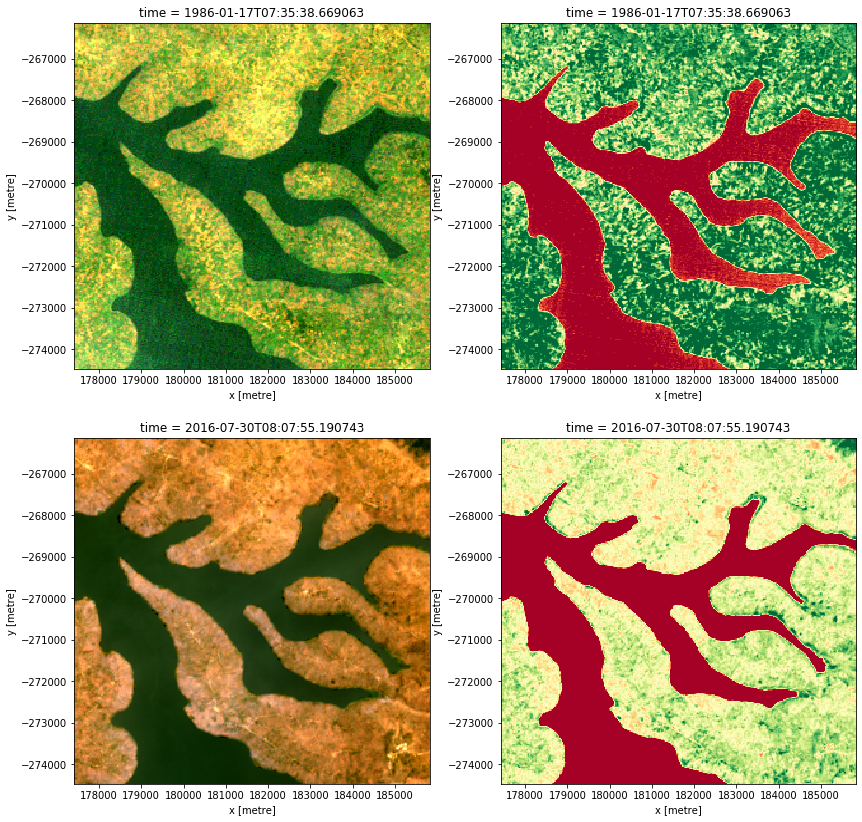

In [202]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(14,14))
ds1.isel(time=0)[rgb_bands].to_array().plot.imshow(robust=True, ax=axes[0,0]);
ds1.isel(time=0)[band_index].plot.imshow(robust=True, ax=axes[0,1], cmap = 'RdYlGn', add_colorbar=False,vmin=0.1, vmax=0.6);

ds2.isel(time=-1)[rgb_bands].to_array().plot.imshow(robust=True, ax=axes[1,0]);
ds2.isel(time=-1)[band_index].plot.imshow(robust=True, ax=axes[1,1], cmap = 'RdYlGn', add_colorbar=False,vmin=0.1, vmax=0.6);


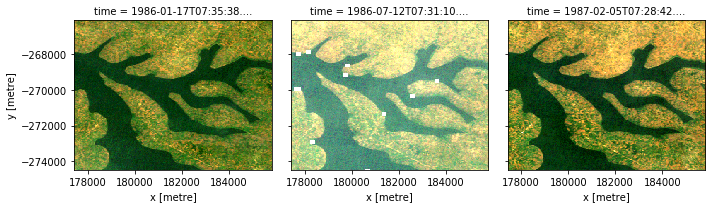

In [203]:
ds1[rgb_bands].to_array().plot.imshow(robust=True, col='time', col_wrap=4);


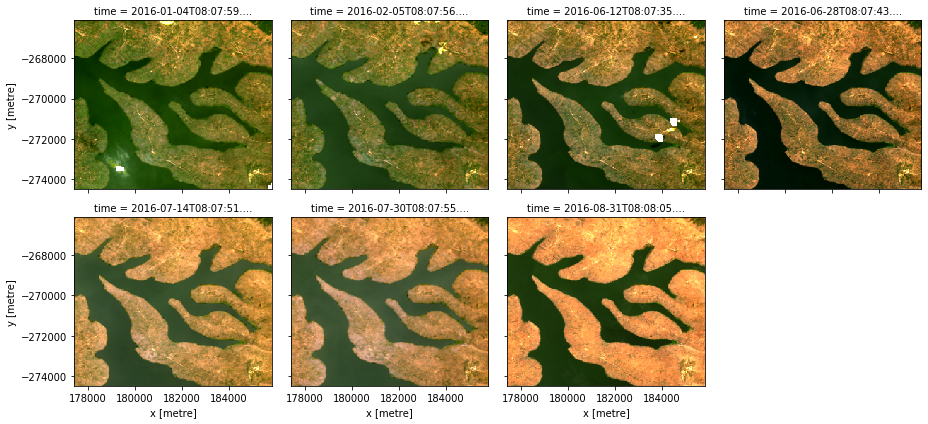

In [209]:
ds2[rgb_bands].to_array().plot.imshow(robust=True, col='time', col_wrap=4);
